# Simulation Library Demo

In [34]:
from class_multisimulation import MultiSimulation
from class_simulationhelper import SimulationHelpers
from class_basesimulation import BaseSimulation
import matplotlib.pyplot as plt

bs = BaseSimulation()
ms = MultiSimulation()
helper = SimulationHelpers()


outlier added at indices 62, 59, 99, 42, 95, 30, 16, 72, 45, 93


Text(0.5, 0, 'Added Outliers')

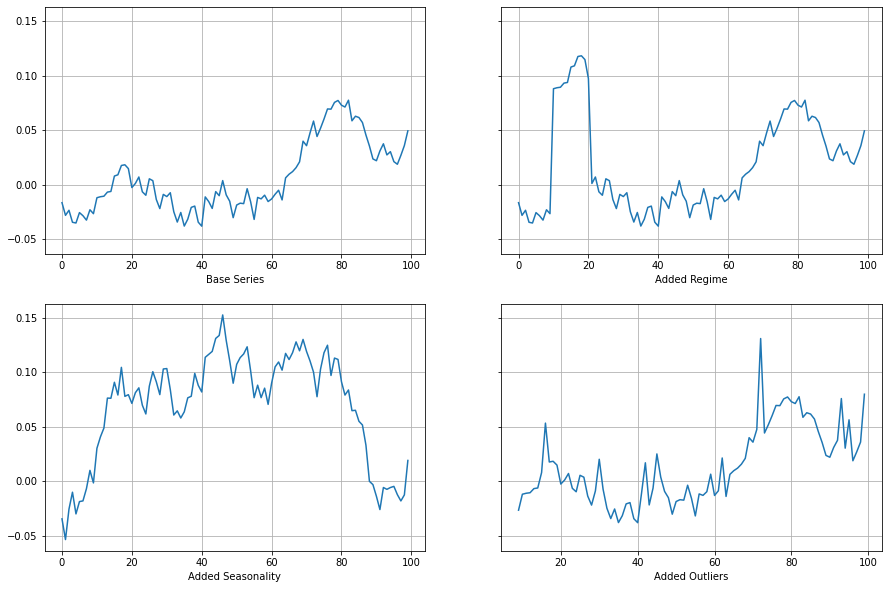

In [35]:
s0 = bs.brownian_process(100, mu = 0, S0 = 1, sigma = 0.1)
s1 = bs.add_regime_change(s0, event_index = 10, shift = 0.1, regime_limit = 10)
s2 = bs.add_seasonality(s0, start_idx = 10, how_diffusion="sqrt", amp = 3, contamination=0.1, freq = 100)
s3 = bs.add_outlier(s0, thresh=3, how = "full_random", count = 10)
ax = helper.plot(s0, s1, s2, s3, figsize=(15, 10), row_lim = 2)
ax[0,0].set_xlabel("Base Series")
ax[0,1].set_xlabel("Added Regime")
ax[1,0].set_xlabel("Added Seasonality")
ax[1,1].set_xlabel("Added Outliers")

outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 20, 35
outlier added at indices 80
outlier added at indices 30


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[66 10 64 45 70 22 89 55 90 45]. Argument 'count' overridden.
  warnings.warn(
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[20, 35]. Argument 'count' overridden.
  warnings.warn(
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[80]. Argument 'count' overridden.
  warnings.warn(
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[30]. Argument 'count' overridden.
  warnings.warn(


Text(0.5, 0.98, 'Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black')

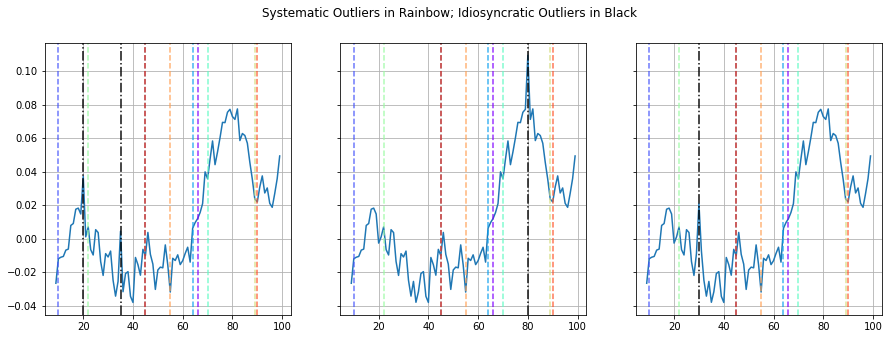

In [36]:
t0 = ms.correlated_brownian_processes_with_CO(100, how = "full_random", count = 10, mu = 0, cov_mat = helper.gen_rand_cov_mat(3, random_seed=12), random_seed=12)
io0 = [20, 35]
io1 = [80]
io2 = [30]
t0[0] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io0)
t0[1] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io1)
t0[2] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io2)
ax = helper.plot(*t0, figsize = (15, 5), outliers = [[66, 10, 64, 45, 70, 22, 89, 55, 90, 45] for _ in range(3)])
for idio in io0:
    ax[0].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io1:
    ax[1].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io2:
    ax[2].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
plt.suptitle("Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black")

In [37]:
# Graph different architecture loss descents
# All copied from new_fit.ipynb
import tensorflow as tf
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generation import gen_data
# from pyod.utils import pairwise_distances_no_broadcast
# from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction, get_outliers

featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 24)

In [38]:
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)


In [39]:
architectures = [
    [128, 64, 64, 128],
    [128, 64, 32, 32, 64, 128],
    [128, 32, 32, 128],
    [64, 32, 32, 64],
    [32, 16, 16, 32],
    [128, 16, 16, 128]
]

histories = {"-".join([str(i) for i in arch]):[] for arch in architectures}

for arch in architectures:
    lstm_pred, lstm_outliers, history = lstm_run(
        LSTM_Model_Base(
            seq_size, 
            n_feature, 
            arch, 
            mid_activation=tf.nn.tanh
        ),
        data_train_seq,
        data_test_seq,
        batch_size=512,
        epoch=100,
        metric="bb",
        early_stopping=False,
        cross_feature_check=True
    )

    histories["-".join([str(i) for i in arch])] = history


Epoch 1/100
3/3 [==============================] - 3s 29ms/step - loss: 1.0156
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0147
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0135
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0113
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0077
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0028
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9983
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9944
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9899
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9851
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9801
Epoch 12/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9747
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 8ms/step
Epoch 1/100


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 4s 35ms/step - loss: 1.0158
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 1.0157
Epoch 3/100
3/3 [==============================] - 0s 35ms/step - loss: 1.0156
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0156
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0154
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 1.0150
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0142
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0123
Epoch 9/100
3/3 [==============================] - 0s 20ms/step - loss: 1.0092
Epoch 10/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0074
Epoch 11/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0056
Epoch 12/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0035
Epoch 13/100
3/3 [==============================] - 0s 15ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 10ms/step
Epoch 1/100


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 4s 27ms/step - loss: 1.0157
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 1.0151
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 1.0143
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 1.0132
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 1.0113
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0086
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0047
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0001
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9963
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9929
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9883
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.9834
Epoch 13/100
3/3 [==============================] - 0s 12ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 7ms/step
Epoch 1/100


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 3s 20ms/step - loss: 1.0157
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0152
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0145
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0136
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0123
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0105
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0082
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 1.0057
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0035
Epoch 10/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0014
Epoch 11/100
3/3 [==============================] - 0s 13ms/step - loss: 0.9992
Epoch 12/100
3/3 [==============================] - 0s 13ms/step - loss: 0.9969
Epoch 13/100
3/3 [==============================] - 0s 14ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 6ms/step
Epoch 1/100


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 3s 17ms/step - loss: 1.0157
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0155
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0153
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0150
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0147
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0142
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0137
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0130
Epoch 9/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0120
Epoch 10/100
3/3 [==============================] - 0s 14ms/step - loss: 1.0108
Epoch 11/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0092
Epoch 12/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0073
Epoch 13/100
3/3 [==============================] - 0s 12ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 5ms/step
Epoch 1/100


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 3s 26ms/step - loss: 1.0158
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 1.0154
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0149
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0142
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0132
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0116
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0092
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0061
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0025
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9989
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.9957
Epoch 12/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9921
Epoch 13/100
3/3 [==============================] - 0s 12ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 7ms/step


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


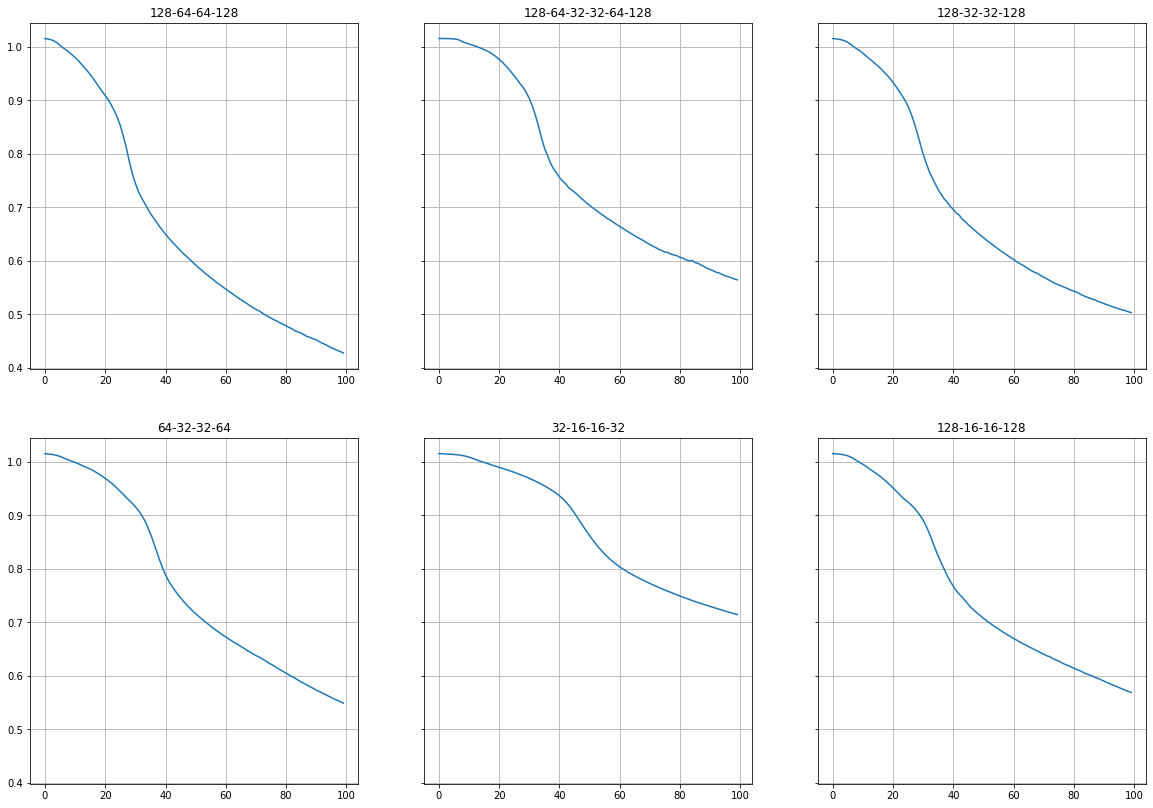

In [40]:
loss = {key: val.history["loss"] for key, val in histories.items()}
ax_loss = helper.plot(*np.array([val for val in loss.values()]), row_lim = 3)
for key, ax in zip(loss.keys(), ax_loss.reshape(-1)):
    ax.set_title(key)

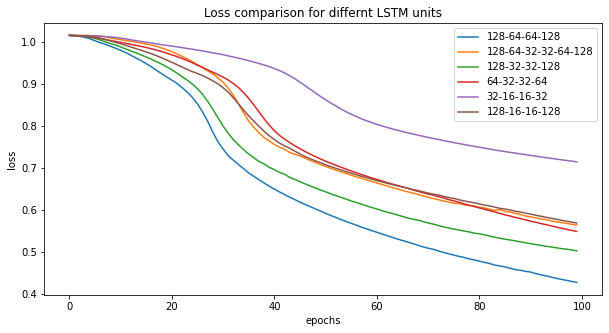

In [50]:
import matplotlib.pyplot as plt

for key, val in loss.items():
    plt.plot(range(len(val)), val, label=key)
# plt.rcParams['figure.figsize'] = [12, 5]

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss comparison for differnt LSTM units")
plt.legend()


In [42]:
# [val for key, val in loss.items()]
np.array([val for val in loss.values()])

array([[1.01563644, 1.0147177 , 1.01346219, 1.01126111, 1.00770342,
        1.00284696, 0.99829608, 0.994412  , 0.98988372, 0.98511589,
        0.98013645, 0.97473639, 0.96828252, 0.96180749, 0.95539093,
        0.94825995, 0.94084108, 0.93262517, 0.92442858, 0.91642326,
        0.90894288, 0.90124518, 0.89127183, 0.88049603, 0.86789405,
        0.85243845, 0.83312345, 0.8106643 , 0.78497326, 0.76186603,
        0.74483913, 0.72902721, 0.71828568, 0.70793605, 0.69820207,
        0.68795854, 0.67993695, 0.671875  , 0.66388214, 0.65655845,
        0.6495989 , 0.64273369, 0.63649195, 0.63034451, 0.62441808,
        0.61852545, 0.61277497, 0.60782635, 0.60242265, 0.59714645,
        0.59181333, 0.5866735 , 0.58206117, 0.57699871, 0.57248956,
        0.56797141, 0.56361115, 0.55893332, 0.55486643, 0.55064404,
        0.54671204, 0.54274273, 0.53873485, 0.53470773, 0.53074938,
        0.52705723, 0.52339458, 0.51973248, 0.51580727, 0.51198012,
        0.50874203, 0.50617999, 0.50223207, 0.49

# Pairwise_distance vs pairwise_distance_no_broadcast

In [51]:
lstm_pred, lstm_outliers, history = lstm_run(
        LSTM_Model_Base(
            seq_size, 
            n_feature, 
            [128,
            64,
            64,
            128
            ]
            , 
            mid_activation=tf.nn.tanh
        ),
        data_train_seq,
        data_test_seq,
        batch_size=512,
        epoch=100,
        metric="bb",
        early_stopping=False,
        cross_feature_check=True
    )

Epoch 1/100
3/3 [==============================] - 4s 28ms/step - loss: 1.0156
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0147
Epoch 3/100
3/3 [==============================] - 0s 30ms/step - loss: 1.0136
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 1.0119
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0088
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0041
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9985
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9947
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9899
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9846
Epoch 11/100
3/3 [==============================] - 0s 13ms/step - loss: 0.9791
Epoch 12/100
3/3 [==============================] - 0s 11ms/step - loss: 0.9730
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 0s 8ms/step


C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
C:\Users\raymo\Documents\GitHub\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


In [63]:
distances = np.mean(np.square(lstm_pred-data_test),axis=1)
lstm_outliers  = np.argsort(distances.reshape(-1))[-8:]
lstm_outliers

array([933, 902, 652, 810, 417, 841, 871, 317], dtype=int64)

Text(0.5, 0.98, 'Sample Run with pairwise_distance_no_broadcast')

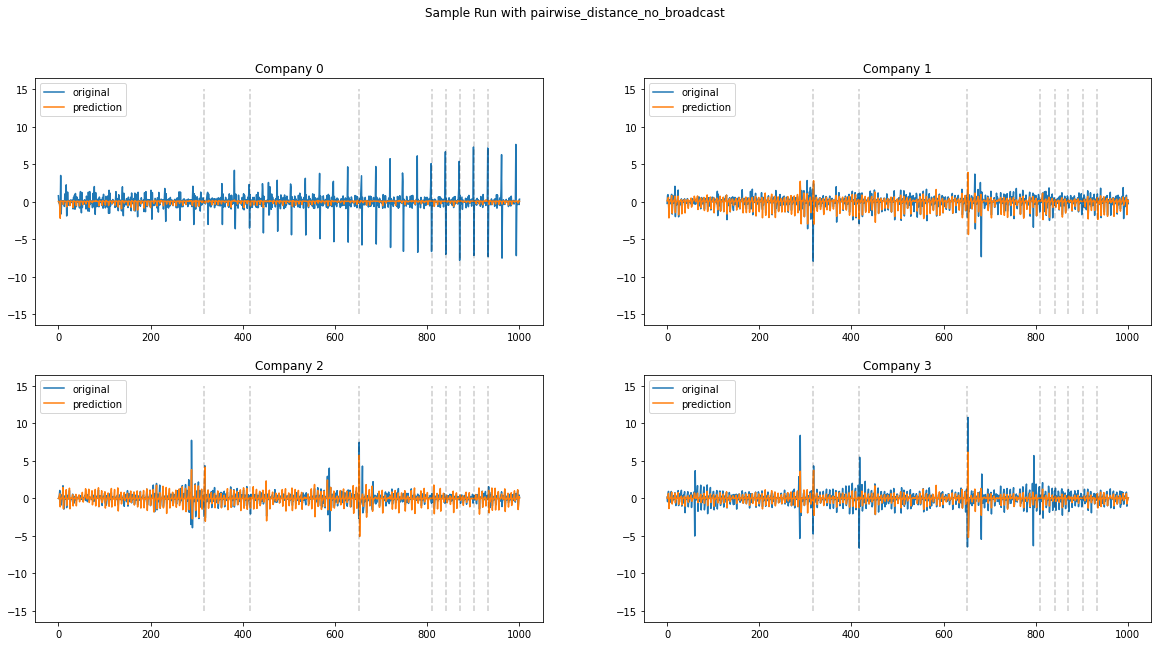

In [69]:

rows = 2
cols = 2

figure, ax = plt.subplots(rows, cols, figsize=(20, 10))

for i in range(rows*cols):
    ax[i//cols][i % cols].plot(range(1002), data_test[:,i], label = "original")
    ax[i//cols][i % cols].plot(range(1002), lstm_pred[:,i], label = "prediction")
#   ax[i//cols][i % cols].grid()
    for o in lstm_outliers:
        ax[i//cols][i % cols].plot([o]*100, np.linspace(-15,15,100), 'k--', alpha = 0.2)
    ax[i//cols][i % cols].set_title(f"Company {i}")
    ax[i//cols][i % cols].legend()
    
figure.suptitle("Sample Run with pairwise_distance_no_broadcast")